### **Load libraries**

In [7]:
sys.path.append('../src')
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Define ticker names**

In [4]:
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

ticker_list_col = list(pd.read_csv(col_stock_list_path, header=None)[0])
ticker_list_glob = list(pd.read_csv(global_stock_list_path, header=None)[0])

In [5]:
""" Alt method
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

with open(col_stock_list_path) as s:
    ticker_list_col = []
    [ticker_list_col.append(l.replace('\n', '')) for l in s]
    s.close()
with open(global_stock_list_path) as s:
    ticker_list_global = []
    [ticker_list_global.append(l.replace('\n', '')) for l in s]
    s.close()
"""

" Alt method\ncol_stock_list_path = 'colombia_stocks_trii.csv'\nglobal_stock_list_path = 'global_stocks_trii.csv'\n\nwith open(col_stock_list_path) as s:\n    ticker_list_col = []\n    [ticker_list_col.append(l.replace('\n', '')) for l in s]\n    s.close()\nwith open(global_stock_list_path) as s:\n    ticker_list_global = []\n    [ticker_list_global.append(l.replace('\n', '')) for l in s]\n    s.close()\n"

In [6]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

### **Extract data from YFinance**

In [7]:
days_of_data = 365*10
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=days_of_data)

In [8]:
#interval = '1d'   # Uncomment for daily data
interval = '1wk'  # Uncomment for weekly data
# interval = '1mo' # Uncomment for monthly data

col_stocks_raw = yf.download(ticker_list_col, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']
global_stocks_raw = yf.download(ticker_list_glob, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']

[*********************100%***********************]  37 of 37 completed

1 Failed download:
['LTMCO.CL']: YFPricesMissingError('possibly delisted; no price data found  (1wk 2015-07-14 -> 2025-07-11)')
[**********************57%**                     ]  28 of 49 completedHTTP Error 404: 
HTTP Error 401: 
[*********************100%***********************]  49 of 49 completed

7 Failed downloads:
['CFMITNIPCO', 'LTMCO', 'IBO1']: YFTzMissingError('possibly delisted; no timezone found')
['SQMBCO.CL', 'ENELAMCO.CL', 'IWVLM.XD', 'ICHNA.XD']: YFPricesMissingError('possibly delisted; no price data found  (1wk 2015-07-14 -> 2025-07-11)')


### **Preprocessing**

In [10]:
# Assign a frequency to the index of the dataframes
# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='D') # Uncomment to set frequency as Daily
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='D') # Uncomment to set ferquency as Daily

col_stocks_raw.index = col_stocks_raw.index.to_period(freq='W') # Uncomment to set frequency as Weekly
global_stocks_raw.index = global_stocks_raw.index.to_period(freq='W') # Uncomment to set ferquency as Weekly

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly

In [11]:
# Merge Col and Global stock prices and returns data
stocks = pd.concat([col_stocks_raw, global_stocks_raw], axis='columns').sort_index()

In [12]:
stocks_not_missing = stocks.columns[stocks.isna().sum() < stocks.shape[0]*.15]

In [13]:
# For days without stock price info, assume the stock price is the same of the previous day
stocks = stocks[stocks_not_missing].fillna(method='bfill')

# Convert from stock prices into returns
rets = stocks.pct_change().iloc[1:]

C:\Users\jumar\AppData\Local\Temp\ipykernel_28744\3483962844.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stocks = stocks[stocks_not_missing].fillna(method='bfill')


In [14]:
# Define start and end dates of the analysis
days_of_analysis = 365*10   # 5 years
end_date = str(datetime.date.today())
start_date = str(datetime.date.today() - datetime.timedelta(days=days_of_analysis))

In [15]:
rets = rets.loc[start_date:end_date]
stocks = stocks.loc[start_date:end_date]

In [16]:
(rets.shape, stocks.shape)

((521, 54), (522, 54))

### **Initial examination**

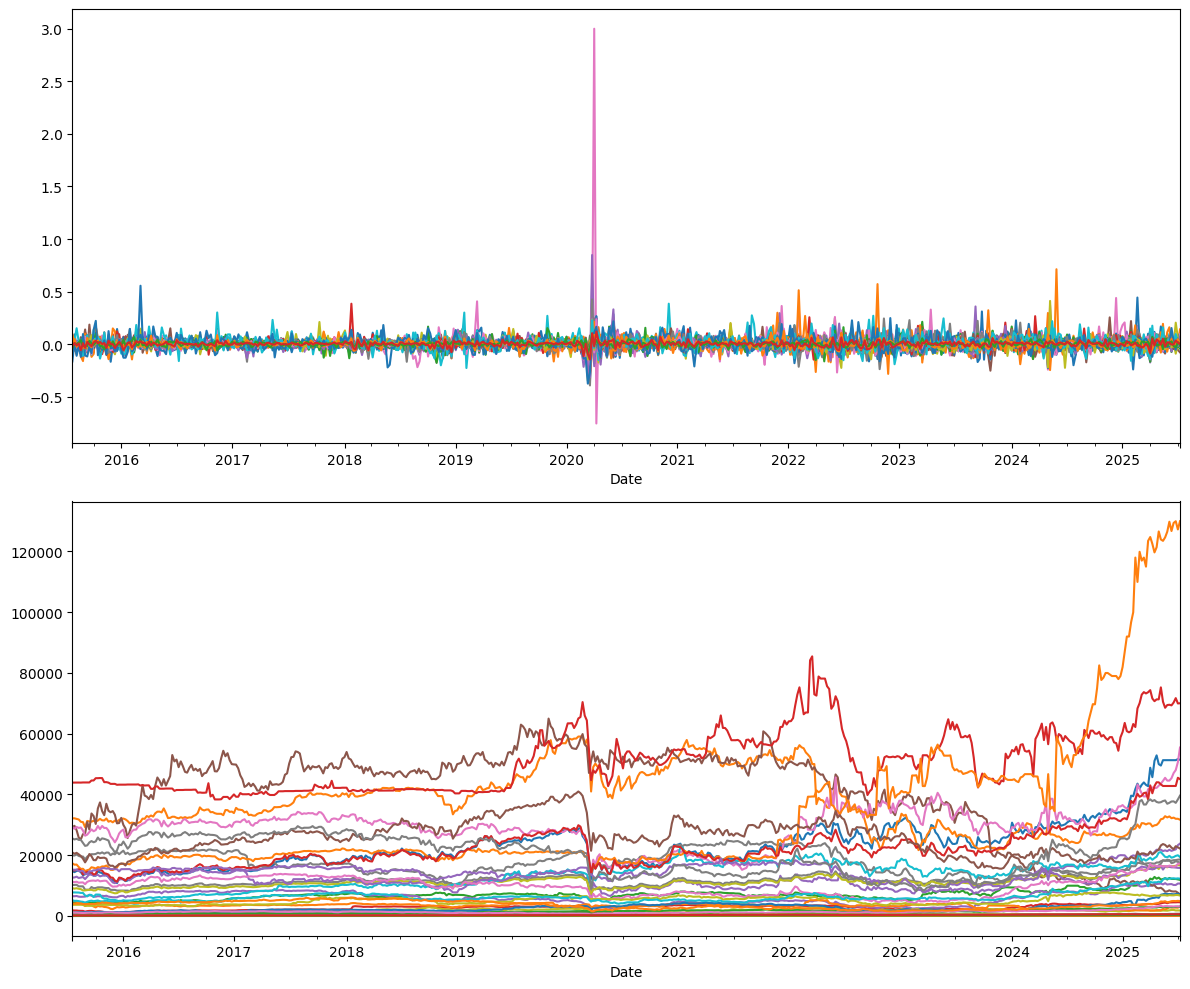

In [17]:
df1_to_plot = rets
df2_to_plot = stocks

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
df1_to_plot.plot(ax = axes[0], legend=False)
df2_to_plot.plot(ax=axes[1], legend=False)
plt.tight_layout()

In [18]:
summary_stats = rk.summary_stats(rets, riskfree_rate=0, periods_per_year=periods_per_year)
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
BCOLOMBIA.CL,0.138068,0.362471,0.373151,14.829191,0.060381,0.096261,0.380909,-0.581655
BOGOTA.CL,-0.001476,0.277299,-0.790863,13.181642,0.061650,0.096779,-0.005323,-0.633000
BVC.CL,0.104468,0.253333,0.687791,7.163756,0.044335,0.069545,0.412373,-0.356135
CELSIA.CL,0.097029,0.288945,2.121839,21.857910,0.020216,0.078573,0.335803,-0.510088
CEMARGOS.CL,0.052794,0.387385,2.723301,42.936748,-0.006200,0.101128,0.136284,-0.782714
CNEC.CL,-0.136546,0.350520,0.490145,7.186705,0.069153,0.099722,-0.389553,-0.891219
CONCONCRET.CL,-0.086547,1.087633,15.779402,323.852722,-2.075313,0.140517,-0.079574,-0.864859
CORFICOLCF.CL,-0.012999,0.290967,0.066530,8.049376,0.059798,0.092212,-0.044676,-0.600359
ECOPETROL.CL,0.052532,0.385211,-0.299150,9.269693,0.081608,0.114029,0.136373,-0.636029


### **Technical Indicators for selected stock**

In [19]:
# Determine a number of periods for the calculation of the moving averages
# MA_terms = 5*4 # Uncomment for daily
MA_terms = 10 # Uncomment for weekly

,PFGRUPSURA.CL,SMA10,EMA10,SMA10 Signal,EMA10 Signal,MACD Signal
Date,,,,,,
2015-07-13/2015-07-19,25543.277344,NaN,25543.277344,False,False,False
2015-07-20/2015-07-26,25193.376953,NaN,25479.659091,False,False,False
2015-07-27/2015-08-02,25403.318359,NaN,25465.778958,False,False,False
2015-08-03/2015-08-09,25053.406250,NaN,25390.802102,False,False,False
2015-08-10/2015-08-16,25039.414062,NaN,25326.913367,False,False,False
...,...,...,...,...,...,...
2025-06-09/2025-06-15,37697.753906,37609.810937,37171.902654,True,True,False
2025-06-16/2025-06-22,37737.371094,37601.124219,37274.715098,True,True,False
2025-06-23/2025-06-29,37242.132812,37509.562109,37268.791046,False,False,False


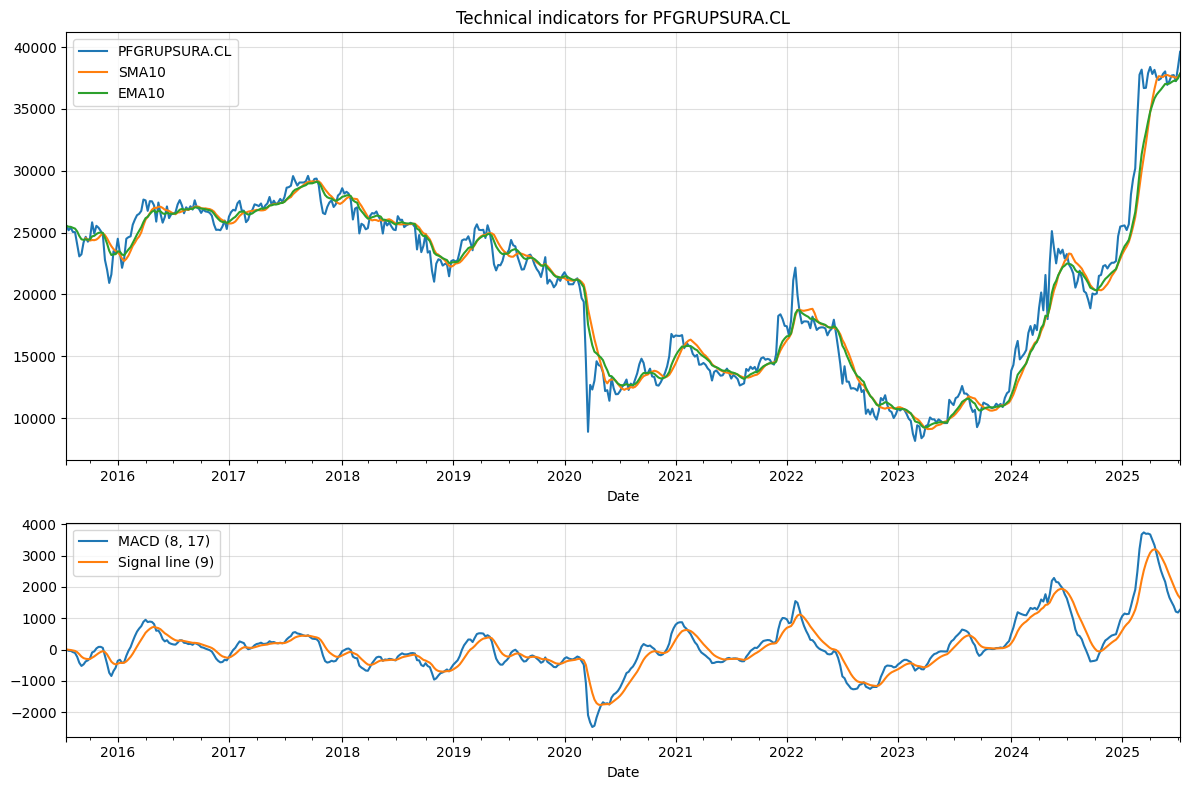

In [20]:
stock = 'PFGRUPSURA.CL' #'BCOLOMBIA.CL'  #'NVDA'
rk.technical_indicators(stocks[stock], time_window=MA_terms, return_df=True, indicators=['SMA', 'EMA', 'MACD'], macd_params=[8, 17, 9])
# rk.technical_indicators(stocks[stock], time_window=MA_terms, return_df=True, indicators=['SMA', 'EMA', 'MACD'], macd_params=[12, 26, 9])

### **Signals across all stocks**

In [21]:
signals = []
for stock in stocks.columns:
    stock_signals = rk.technical_indicators(stocks[stock], indicators=['SMA', 'EMA', 'MACD'], time_window=MA_terms, macd_params=[12, 26, 9], return_df=True, plot=False, signal_tolerance=.975).iloc[-1]
    stock_signals = pd.DataFrame(stock_signals).T
    stock_signals.index = [stock]
    stock_signals.rename(columns={stock: 'Price'}, inplace=True)
    signals.append(stock_signals)

signals = pd.concat(signals, axis=0)

In [22]:
signals

,Price,SMA10,EMA10,SMA10 Signal,EMA10 Signal,MACD Signal
BCOLOMBIA.CL,51440.0,51170.0,50726.20732,True,True,False
BOGOTA.CL,31700.0,32224.064648,31824.547852,True,True,False
BVC.CL,11900.0,12166.0,12074.988712,True,True,False
CELSIA.CL,4520.0,4410.5,4384.532037,True,True,True
CEMARGOS.CL,10680.0,10494.993359,10464.247876,True,True,False
CNEC.CL,7070.0,8165.0,8208.92592,False,False,False
CONCONCRET.CL,458.0,479.2,476.688226,False,False,False
CORFICOLCF.CL,17580.0,17902.0,17670.575393,True,True,False
ECOPETROL.CL,1810.0,1834.5,1838.600995,True,True,True
ENKA.CL,18.299999,18.28,18.24907,True,True,True


### **Stock filtering by signal**

In [23]:
signals_filtered = signals[np.int64(signals['MACD Signal']) + np.int64(signals[f'SMA{MA_terms} Signal']) + np.int64(signals[f'EMA{MA_terms} Signal']) >= 2]

In [24]:
selected_stocks_rets = rets[signals_filtered.index]
selected_stocks_stocks = stocks[signals_filtered.index]

In [25]:
selected_stocks_rets.index = selected_stocks_rets.index.astype('str').str.split('/').str[1]
selected_stocks_stocks.index = selected_stocks_stocks.index.astype('str').str.split('/').str[1]

rets.index = rets.index.astype('str').str.split('/').str[1]
stocks.index = stocks.index.astype('str').str.split('/').str[1]

### **Export datasets and an index for the Sharpe-Ratio maximizing allocation**

In [26]:
# Selected stocks dataset
selected_stocks_rets.to_csv('selected_stocks_rets.csv')
selected_stocks_stocks.to_csv('selected_stocks_stocks.csv')

# Concatenated returns and stock prices datasets
rets.to_csv('all_rets.csv')
stocks.to_csv('all_stocks.csv')